# CART

In this notebook we give a take on the CART algorithm used to train decision trees.

The objective function for a _greedy_ decision tree model is given by $(i, j)$ such that 

$$
    \min_{i, j}\left[\sum_{\{i | x_i \in R_1(j, s)\}}(y_i - \hat c_1)^2 + \sum_{\{i | x_i \in R_2(j, s)\}}(y_i - \hat c_2)^2\right]
$$

Where,

$$
    \hat c_k = \frac{1}{N_k}\sum_{\{n|x_n\in R_k(j, s)\}} x_n
$$

That is, our search algorithm's goal is to find, for each input dimension $j$, the value $s$ that minimizes the error term

In [1]:
import numpy as np
from numpy.random import seed, multivariate_normal
import matplotlib.pyplot as plt
from matplotlib import style

In [2]:
%config InlineBackend.figure_format = "retina"
style.use("seaborn-white")
plt.rcParams.update({'font.size': 15})

In [3]:
def Ri(X, j, s):
    """
    Considering a dataset X, compute whether
    each of the observations belong to R1 or R2.
    We assing an observation x to be in R1 if
    x_j <= s; otherwise we asign it to R2. In other words,
    we define the subset R1 of X as
    
    R1 = {x | x_j <= s};
    R2 = X - R1
    """
    return X[:, j] <= s

def RSS(y):
    return np.mean((y - y.mean()) ** 2)

def tree_erf(X, y, j, s):
    """
    Compute the objective error function for a decision tree model
    considering an index j in [0, .., D -1] and a cutoff point s.
    
    Parameters
    ----------
    X: Numpy array
        Dataset of shape (N, K)
    y: Numpy array
        Dataset of shape (N,)
    j: int
        The dimension to evaluate
    s: float
        The cutoff point
    """
    return RSS(y[Ri(X, j, s)]) + RSS(y[~Ri(X, j, s)])

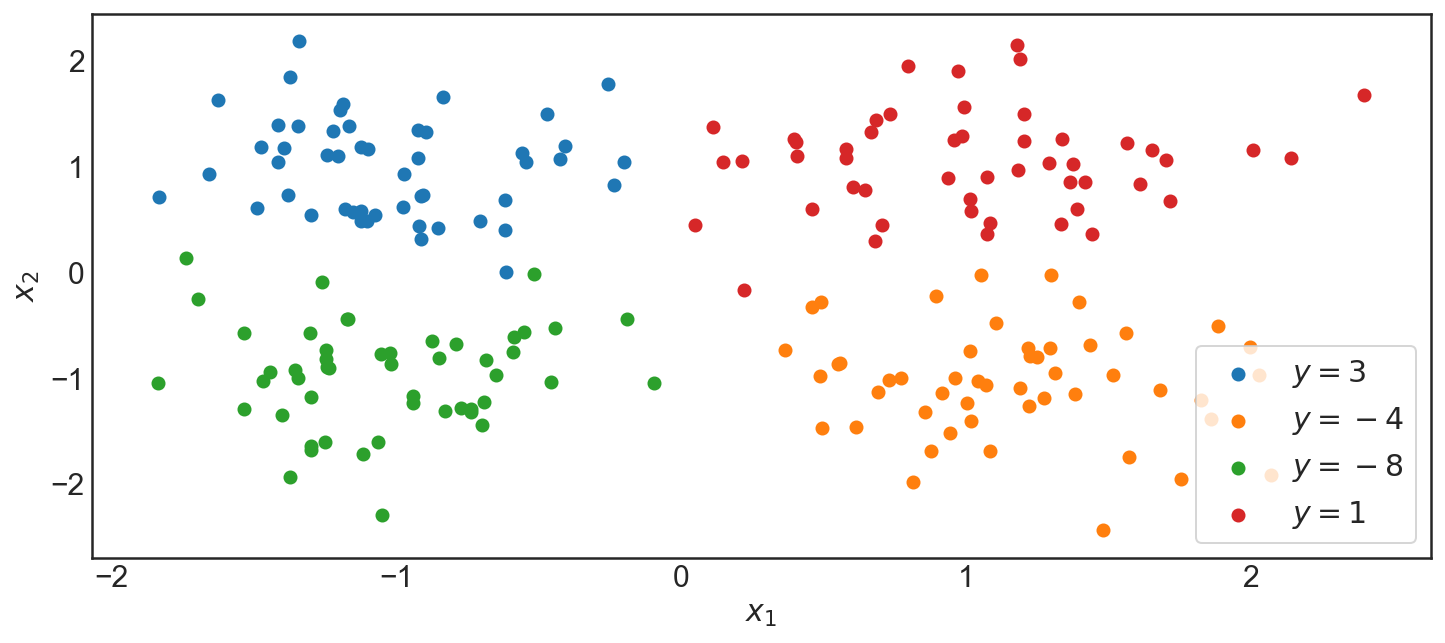

In [4]:
seed(314)
plt.figure(figsize=(12, 5))
D1 = multivariate_normal([-1, 1], np.identity(2) * 0.2, 50)
D2 = multivariate_normal([ 1,-1], np.identity(2) * 0.2, 50)
D3 = multivariate_normal([-1,-1], np.identity(2) * 0.2, 50)
D4 = multivariate_normal([ 1, 1], np.identity(2) * 0.2, 50)

plt.scatter(*D1.T, label="$y=3$")
plt.scatter(*D2.T, label="$y=-4$")
plt.scatter(*D3.T, label="$y=-8$")
plt.scatter(*D4.T, label="$y=1$")
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.legend(facecolor="white", frameon=True, loc="lower right")

In [5]:
seed(271)
y1 = np.random.randn(50) + 3
y2 = np.random.randn(50) - 4
y3 = np.random.randn(50) - 8
y4 = np.random.randn(50) + 1

In [6]:
D = np.r_[D1,D2, D3, D4]
y = np.r_[y1, y2, y3, y4]

For fixed, $j$, let us compute $s$ that minimizes the clases

----

### Considering the first dimension

In [7]:
s = 0.4
j = 0 # The target dimension that will be used to locally minimze
RSS(y[Ri(D, j, s)]) + RSS(y[~Ri(D, j, s)])

37.899908547810846

In [8]:
j = 0
vmin, vmax = D[:,j].min(), D[:,j].max() * 0.99
srange = np.linspace(vmin, vmax,  10)
s = min([(sh, tree_erf(D, y, j, sh)) for sh in srange], key=lambda v: v[1])

In [9]:
s

(-1.83711149535837, 19.770053850280352)

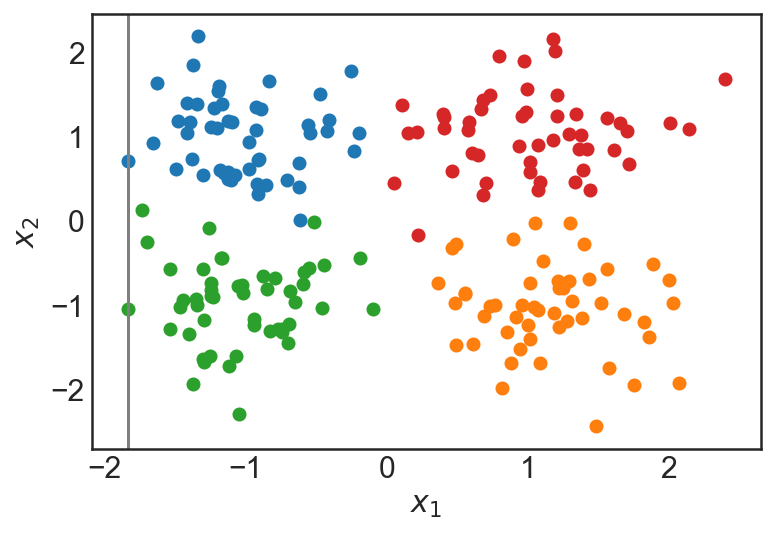

In [10]:
plt.scatter(*D1.T)
plt.scatter(*D2.T)
plt.scatter(*D3.T)
plt.scatter(*D4.T)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")

plt.axvline(x=s[0], c="tab:gray")

### Considering the second dimension

In [11]:
j = 1
vmin, vmax = D[:,j].min(), D[:,j].max() * 0.99
srange = np.linspace(vmin, vmax,  10)
s = min([(sh, tree_erf(D, y, j, sh)) for sh in srange], key=lambda v: v[1])

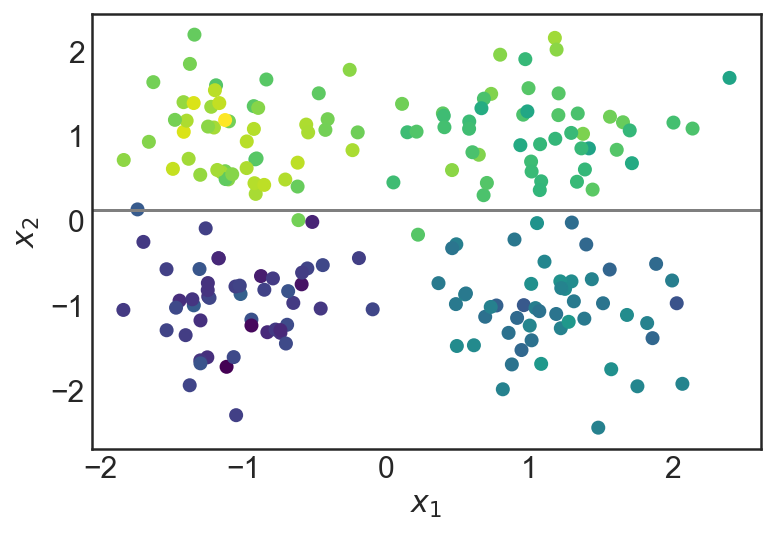

In [12]:
plt.scatter(*D.T, c=y, cmap="viridis")
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")

plt.axhline(y=s[0], c="tab:gray")

In [13]:
s

(0.12208122460399329, 9.292897896689059)

## Creating the Tree

From this past example we see that $j=0$ minimizes the greedy-objetive function. Thus, given a new observation $x$, we first verify whether $x \leq s \approx -0.10$

In [14]:
class Tree:
    def __init__(self):
        self.right = None
        self.left = None
        self.data = None

In [15]:
t = Tree()
t.data = (1, s[0], None)

t.left = Tree()
t.left.data = y[Ri(D, t.data[0], t.data[1])].mean()

t.right = Tree()
t.right.data = y[~Ri(D, t.data[0], t.data[1])].mean()

In [16]:
Dsub = D[Ri(D, t.data[0], t.data[1])]
ysub = y[Ri(D, t.data[0], t.data[1])]

In [17]:
j = 0
vmin, vmax = Dsub[:,j].min(), Dsub[:,j].max() * 0.99
srange = np.linspace(vmin, vmax,  10)
s = min([(sh, tree_erf(Dsub, ysub, j, sh)) for sh in srange], key=lambda v: v[1])
s

(-0.10955002584312856, 5.104517329640506)

(-2.6837810881884105, 2.438006166506145)

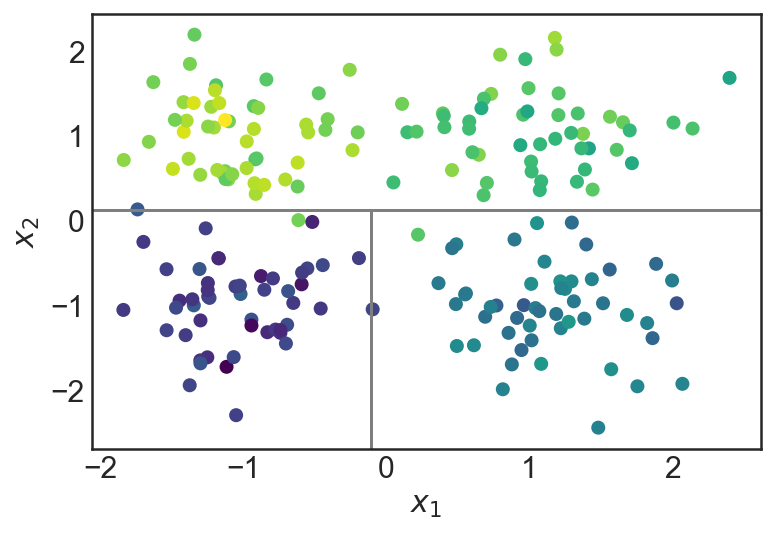

In [18]:
plt.scatter(*D.T, c=y, cmap="viridis")
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")

plt.axhline(y=0.12208, c="tab:gray")
vymin, vymax = plt.ylim()
plt.vlines(x=-0.10955, ymin=vymin, ymax=0.12208, color="tab:gray")
plt.ylim(vymin, vymax)

In [19]:
# Values greater than s
Dsub = D[~Ri(D, t.data[0], t.data[1])]
ysub = y[~Ri(D, t.data[0], t.data[1])]

In [20]:
j = 1
vmin, vmax = Dsub[:,j].min(), Dsub[:,j].max() * 0.99
srange = np.linspace(vmin, vmax,  10)
s = min([(sh, tree_erf(Dsub, ysub, j, sh)) for sh in srange], key=lambda v: v[1])
s

(0.13324561506511157, 2.2992352728108703)

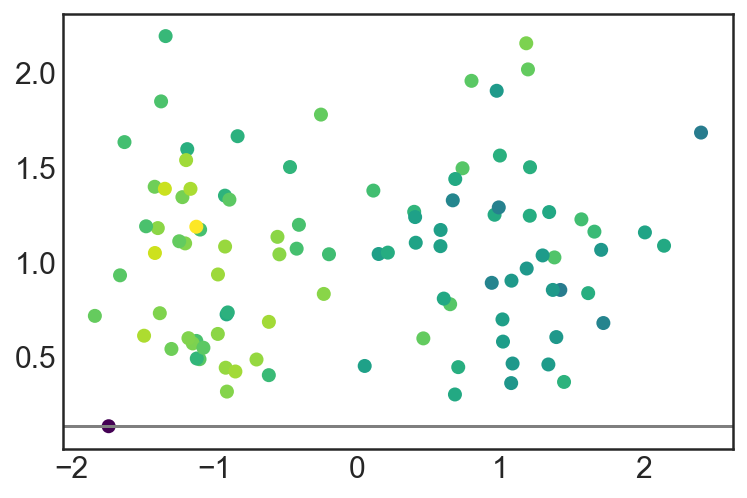

In [21]:
plt.scatter(*Dsub.T, c=ysub, cmap="viridis")
plt.axhline(y=_20[0], c="tab:gray")

In [22]:
Dsub2 = Dsub[~Ri(Dsub, 1, s[0])]
ysub2 = ysub[~Ri(Dsub, 1, s[0])]

In [23]:
j = 1
vmin, vmax = Dsub2[:,j].min(), Dsub2[:,j].max() * 0.99
srange = np.linspace(vmin, vmax,  20)
s = min([(sh, tree_erf(Dsub2, ysub2, j, sh)) for sh in srange], key=lambda v: v[1])
s

(0.3007026188339945, 2.3132368615536745)

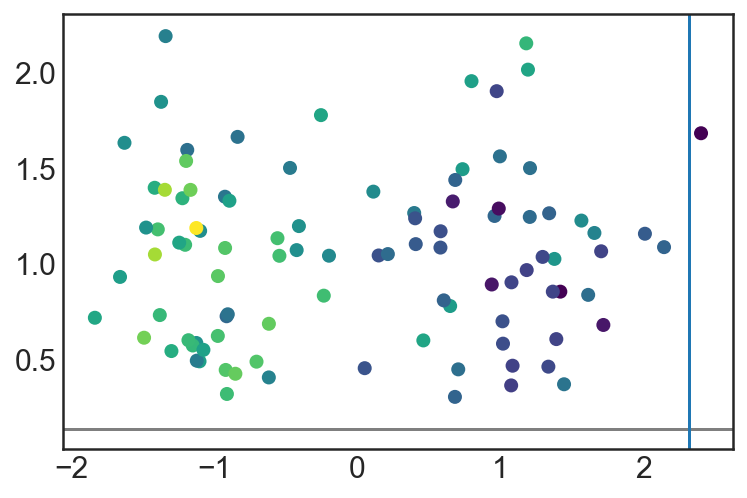

In [24]:
plt.scatter(*Dsub2.T, c=ysub2, cmap="viridis")
plt.axhline(y=_20[0], c="tab:gray")
plt.axvline(x=_23[1])

(-2.6837810881884105, 2.438006166506145)

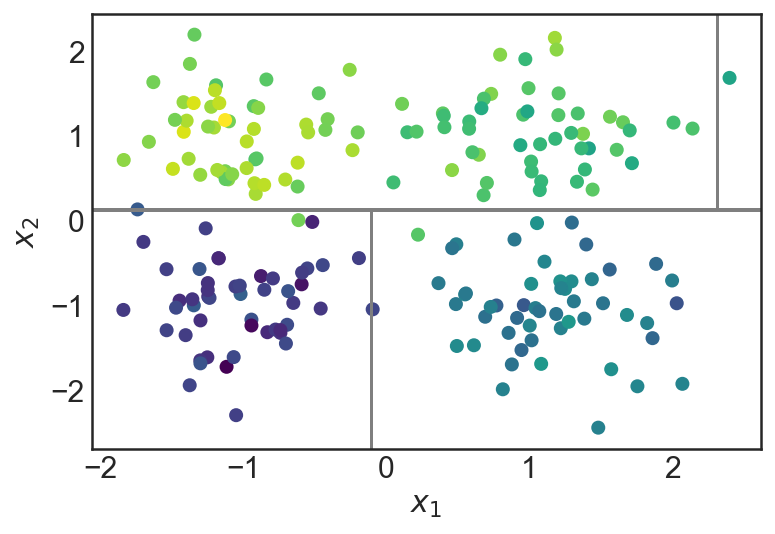

In [25]:
plt.scatter(*D.T, c=y, cmap="viridis")
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")

plt.axhline(y=0.12208, c="tab:gray")
vymin, vymax = plt.ylim()
plt.vlines(x=-0.10955, ymin=vymin, ymax=0.12208, color="tab:gray")
plt.axhline(y=_20[0], c="tab:gray")
plt.vlines(x=_23[1], ymin=_20[0], ymax=vymax, color="tab:gray")
plt.ylim(vymin, vymax)

## The tree

According to Tibshirani et al, 
> The preferred strategy is to grow a large tree $T_0$, stopping the splitting process only when some minimum node size (say 5) is reached